In [23]:
import soundfile as sf
import numpy as np
import random
import os
from tqdm import tqdm
from librosa.feature import melspectrogram

In [24]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [25]:
def read_data(data_dir, segement_len):
    data = []
    for dirpath, _, filelist in tqdm(os.walk(data_dir)):
        for filename in filelist:
            data_dir = os.path.join(dirpath, filename)
            x, samplerate = sf.read(data_dir)
            if len(x) > segement_len:
                start = random.randint(0, len(x)-segement_len)
                x = x[start:start+segement_len]
            else:
                x = np.concatenate((x, np.zeros((segement_len-len(x),))))
            x = melspectrogram(y=x, sr=samplerate, n_fft=512, hop_length=160, win_length=400, n_mels=40, fmin=0.0, fmax=8000)
            y = int(filename.split("_")[0][-3:])
            data.append((x, y))
    return np.array(data)

data = read_data("./train", 16000*2)

251it [03:22,  1.24it/s]
C:\Users\GuotongWu\AppData\Local\Temp\ipykernel_18784\2688674153.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [26]:
class SoundTrainValidDataset(Dataset):
    def __init__(self, data, type):
        shuffle_indices = np.arange(len(data))
        np.random.shuffle(shuffle_indices)
        if type == 'train':
            indices = shuffle_indices[:len(shuffle_indices)//10*6]
        else:
            indices = shuffle_indices[len(shuffle_indices)//10*6:]
        self.data = np.array(data)[indices]
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index][0], dtype=torch.float32), torch.tensor(self.data[index][1], dtype=torch.int64)

In [27]:
trainDataset = SoundTrainValidDataset(data=data, type='train')
trainDataloader = DataLoader(trainDataset,batch_size=512, shuffle=True)
validDataset = SoundTrainValidDataset(data=data, type="valid")
validDataloader = DataLoader(validDataset, batch_size=512, shuffle=False)

input = list(trainDataloader)[0][0]
input.shape


torch.Size([512, 40, 201])

In [28]:
class VGGVox(nn.Module):
    def __init__(self, nOut=251, encoder_type='SAP', log_input=False, **kwargs):
        super(VGGVox, self).__init__()

        print('Embedding size is %d, encoder %s.'%(nOut, encoder_type))
        
        self.encoder_type = encoder_type
        self.log_input    = log_input

        self.netcnn = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=(5,7), stride=(1,2), padding=(2,2)),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(1,3), stride=(1,2)),

            nn.Conv2d(96, 256, kernel_size=(5,5), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),

            nn.Conv2d(256, 384, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),

            nn.Conv2d(256, 512, kernel_size=(4,1), padding=(0,0)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
        )

        if self.encoder_type == "MAX":
            self.encoder = nn.AdaptiveMaxPool2d((1,1))
            out_dim = 512
        elif self.encoder_type == "TAP":
            self.encoder = nn.AdaptiveAvgPool2d((1,1))
            out_dim = 512
        elif self.encoder_type == "SAP":
            self.sap_linear = nn.Linear(512, 512)
            self.attention = self.new_parameter(512, 1)
            out_dim = 512
        else:
            raise ValueError('Undefined encoder')

        self.fc = nn.Linear(out_dim, nOut)

        self.instancenorm   = nn.InstanceNorm1d(40)

    def new_parameter(self, *size):
        out = nn.Parameter(torch.FloatTensor(*size))
        nn.init.xavier_normal_(out)
        return out
        
    def forward(self, x):

        with torch.no_grad():
            x = x + 1e-6
            if self.log_input: x = x.log()
            x = self.instancenorm(x).unsqueeze(1)

        x = self.netcnn(x)

        if self.encoder_type == "MAX" or self.encoder_type == "TAP":
            x = self.encoder(x)
            x = x.view((x.size()[0], -1))

        elif self.encoder_type == "SAP":
            x = x.permute(0, 2, 1, 3)
            x = x.squeeze(dim=1).permute(0, 2, 1)  # batch * L * D
            h = torch.tanh(self.sap_linear(x))
            w = torch.matmul(h, self.attention).squeeze(dim=2)
            w = F.softmax(w, dim=1).view(x.size(0), x.size(1), 1)
            x = torch.sum(x * w, dim=1)

        x = self.fc(x)
        x = nn.Softmax(dim=1)(x)

        return x

In [29]:
def valid(valid_loader, net, device, criterion):
    net.eval()
    total_loss = 0
    total_acc = 0

    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = net(x)
            loss = criterion(pred, y).item()
            total_loss += loss * len(x)
            total_acc += (pred.argmax(dim=1) == y).to(torch.float32).mean().item() * len(x)

    return  total_loss/len(valid_loader.dataset), total_acc/len(valid_loader.dataset)

In [30]:
# os.system('nvidia-smi -q -d Memory | grep -A4 GPU|grep Free >tmp')
# memory_gpu = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
# os.system('rm tmp')  

# memory_gpu = np.array(memory_gpu)
# gpu = np.argmax(memory_gpu)
gpu = 0
print(gpu)

from VGGVox import VGGVox
net = VGGVox(nOut=251, encoder_type="SAP", log_input=False).to(gpu)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_acc = []
dev_loss = []
dev_acc = []
min_loss = 10000
early_stop_cnt = 0
epoch = 300
early_stop = 50

for _ in range(epoch):
    for x, y in trainDataloader:
        net.train()
        x, y = x.to(device=gpu), y.to(device=gpu)
        pred = net(x)

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_acc.append((pred.argmax(dim=1) == y).to(torch.float32).mean().item())
    loss, acc = valid(validDataloader, net, gpu, criterion)
    dev_loss.append(loss)
    dev_acc.append(acc)

    if loss < min_loss:
        min_loss = loss        
        torch.save(net.state_dict(), './saved_model/net.pt')
        print('Saving Model: ', _, '|' ,epoch,"  " ,acc , '  ', loss)

        early_stop_cnt = 0
    else:
        early_stop_cnt += 1

    if early_stop_cnt > early_stop:
        break  

0
Embedding size is 251, encoder SAP.
Saving Model:  0 | 300    0.006040992449563169    5.525187331470214
Saving Model:  1 | 300    0.008522114348160796    5.520904631136305
Saving Model:  2 | 300    0.011434735708187828    5.519926382268517
Saving Model:  3 | 300    0.01197411003316619    5.51928539769935
Saving Model:  4 | 300    0.016936353830361444    5.517129631515717
Saving Model:  6 | 300    0.01790722761596548    5.514652582022493
Saving Model:  9 | 300    0.022761596550415507    5.508265767617004
Saving Model:  11 | 300    0.033225458471391835    5.503708481814354
Saving Model:  19 | 300    0.03290183387511885    5.500847408558044
Saving Model:  24 | 300    0.04261057174000025    5.498359589026327
Saving Model:  28 | 300    0.04304207120062593    5.49094253558557
Saving Model:  40 | 300    0.04875943907642056    5.487744856343686
Saving Model:  63 | 300    0.04875943905552357    5.485125363914712
Saving Model:  77 | 300    0.048867313920679986    5.483711199570114


In [31]:
len(trainDataloader.dataset)

13902

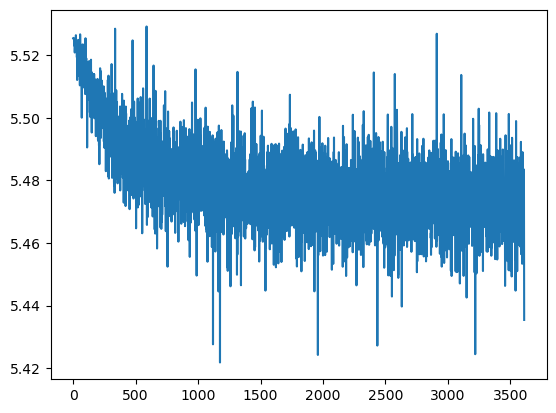

In [34]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)